# Lab 4: Pointwise Mutual Information

This lab is about applications of _Pointwise Mutual Information_ (PMI) in natural language processing.


### Tasks

1. Find **collocations** with PMI.
2. Create **dense vector representations** for words (also known as **word embeddings**) by taking the singular value decomposition of a PMI co-occurence matrix.

### Rules
* The lab exercises should be made in **groups of two people**.

* The deadline is **Sunday 10 Dec 23:59**.

* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be `lab4_lastname1_lastname2.ipynb`, so for example `lab4_Levy_Goldberg.ipynb`.

* The notebook is graded on a scale of **0-100**. The number of points for each question is indicated in parantheses. 

Notes on implementation:

* You should **write your code and answers in this iPython Notebook** (see http://ipython.org/notebook.html for reference material). If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `# YOUR CODE HERE` comment.
    
    * For theoretical question, put your solution in the YOUR ANSWER HERE cell.
    
* Test your code and **make sure we can run your notebook**



In [1]:
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import operator
from scipy.sparse import coo_matrix
%matplotlib inline

# PMI

**Point-wise mutual information** is a measure of association used in information theory and statistics. In the words of [Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/15.pdf):

> The point-wise mutual information is a measure of how often two events $x$ and $y$ occur, compared with what we would expect if they were independent.

It is formally defined as follows. Let $x$ and $y$ be outcomes of discrete random variables $X$ and $Y$. Then the point-wise mutual information between $x$ and $y$ is 

$$PMI(x,y) = \log\frac{p(x,y)}{p(x)p(y)}.$$

The values for $PMI$ range between minus and plus infinity. Large positive values indicate that $x$ and $y$ are strongly associated. A $PMI$ of zero means $x$ and $y$ are completely independent. And because of the logarithm, the values can also be negative, which indicates that $x$ and $y$ are co-occurring _less often_ than we would expect by chance. Negative values tend to be unreliable though, often resulting from the lack of coocurence statistics for $x$ and $y$. A more robust measure therefore is a variant of $PMI$ called the $Positive$ $PMI$:

$$PPMI(x,y) = \max(0, PMI(x, y)).$$

In NLP applications, the $x$ and $y$ in the definition above are generally words, and the distributions based on their occurence in a text-corpus. Therefore from now on, let's refer to $x$ and $y$ as $w_i$ and $w_j$.

----- 

You can read more about $PMI$ and $PPMI$ in the following sources:

* [Jurafsky and Martin 15.2](https://web.stanford.edu/~jurafsky/slp3/15.pdf) is dedicated to $PMI$
* The [Wikipedia entry on PMI](https://en.wikipedia.org/wiki/Pointwise_mutual_information) (it even has a language-related application of $PMI$)

----- 


# Co-occurrence statistics

To compute the $PMI$ of two words $w_i$ and $w_j$ we need the probabilities $p(w_i)$, $p(w_j)$ and $p(w_i,w_j)$. What are they?

### Unigram

The probabilites $p(w_i)$ and $p(w_j)$ are the probabilities of the words occuring by themselves in the corpus: they are the unigram probabilities of $w_i$ and $w_j$. We have seen before how to get these.

### Skip-gram

The probability $p(w_i, w_j)$ is the probability of $w_i$ and $w_j$ co-occuring together in the corpus. Co-occurrence is often modelled with a **skip-gram** model. A skip-gram collects the co-occurence statistics of a word with the words that surround it within some fixed **context window**, to the left of the word, and to the right of the word. 

Consider the following fragment of a sentence in which a context window of 3 words around the word _fox_ are shown:

> ... the quick brown **fox** jumped over the ...

The skipgram counts that we then extract from this fragment are 

$$C(quick, fox) = C(brown, fox)= C(jumped, fox) = C(over, fox) = 1,$$

and 

$$C(the, fox) = 2.$$

After all theses counts have been collected, we normalize and divide, giving probabilities $p(quick, fox), p(brown, fox)$ etc. such that

$$\sum_{\{w,v\}} p(w,v) = 1.$$

**[Note]** The word-pairs $\{w,v\}$ are **unordered**. So $p(quick, fox) = p(fox, quick)$.

----

We have provided you below with all the code nessecary to obtain these distributions. Read this through, and pay some attention to the methods that they are provided with. These will be usefull in some of the questions.

---

## Read in data

As always, we will obtain the distributions from a large text corpus. To read in such a text we provide you with the following class:

In [2]:
class TextData:
    """
    Stores text data with additional attributes.
    :param fname: a path to a txt file
    """
    def __init__(self, fname):
        self._fname = fname
        self._data = []
        self._w2i = defaultdict(lambda: len(self._w2i))
        self._i2w = dict()
        self._counter = Counter()
        self._ntokens = 0    # number of tokens in dataset
        
        self._read()
        
    def _read(self):
        with open(self._fname, "r") as fh:
            for line in fh:
                tokens = line.strip().lower().split()
                self._data.append(tokens)
                self._counter.update(tokens)
        
        # Store number of tokens in the text
        self._ntokens = sum(self._counter.values())
        
        # Store the words in w2i in order of frequency from high to low
        for word, _ in self._counter.most_common(self._ntokens):
            self._i2w[self._w2i[word]] = word
        
    def __len__(self):
        """
        Number of tokens in the dataset
        """
        return self._ntokens
    
    @property
    def data(self):
        """
        The data as list of lists
        """
        return self._data
    
    @property
    def counter(self):
        """
        The word-counts as counter
        """
        return self._counter
    
    @property
    def vocab_size(self):
        """
        Number of words in the dataset
        """
        return len(self._w2i)
    
    @property
    def w2i(self):
        """
        Word to index dictionary
        Words are sorted in order of frequency from high to low
        """
        return self._w2i
    
    @property
    def i2w(self):
        """
        Inverse dictionary of w2i: index to words
        """
        return self._i2w

## Unigram and Skipgram

To train unigram and skipgram language models, you can use the following code.

In [3]:
class Unigram:
    """
    A unigram language model
    """
    def __init__(self, data):
        self._data = data
        self._unigram_counts = defaultdict(int)
        self._unigram_probs = defaultdict(float)
        self._unigram_counter = Counter()
        self._unigram_distribution = Counter()
        self._train()
        
    def _train(self):
        """
        Trains the model trained on data
        """
        # Get the word counts
        for sent in self._data:
            for word in sent:
                self._unigram_counts[word] += 1
            
        # Normalize the word counts
        s = sum(self._unigram_counts.values())
        for word_pair, count in self._unigram_counts.items():
            self._unigram_probs[word_pair] = count / s
        
        # There are some advantages to additionally use a Counter
        self._unigram_counter = Counter(self._unigram_counts)
        self._unigram_distribution = Counter(self._unigram_probs)
        
    def prob(self, w):
        """
        Returns the unigram probability p(w)
        """
        return self._unigram_probs[w]
    
        
    def count(self, w):
        """
        Returns the unigram count c(w)
        """
        return self._unigram_counts[w]
    
    @property
    def data(self):
        """
        Returns the data
        """
        return self._data

    @property
    def counter(self):
        """
        Returns the unigram counts as Counter
        """
        return self._unigram_counter
    
    @property
    def distribution(self):
        """
        Returns the unigram distribution as Counter
        """
        return self._unigram_distribution
    
    
class Skipgram:
    """
    A skip-gram language model
    Note: p(w,v) = p(v,w)
    """
    def __init__(self, data, context_window=5):
        self._data = data
        self._context_window = context_window
        self._skipgram_counts = defaultdict(int)
        self._skipgram_probs = defaultdict(float)
        self._skipgram_counter = Counter()
        self._skipgram_distribution = Counter()
        self._train()
        
    def _train(self):
        """
        Trains the model
        """
        # Get the co-occurrence counts
        for sent in self._data:
            for i in range(self._context_window, len(sent) - self._context_window):
                context = [sent[i - j] for j in range(1, self._context_window + 1)] + \
                          [sent[i + j] for j in range(1, self._context_window + 1)]    
                w = sent[i]
                for v in context:
                    word_pair = tuple(sorted([w, v])) # causes p(w,v) = p(v,w)
                    self._skipgram_counts[word_pair] += 1
            
        # Turn the co-occurrence counts into probabilities
        s = sum(self._skipgram_counts.values())
        for word_pair, count in self._skipgram_counts.items():
            self._skipgram_probs[word_pair] = count / s
        
        # There are some advantages to additionally use a Counter
        self._skipgram_counter = Counter(self._skipgram_counts)
        self._skipgram_distribution = Counter(self._skipgram_probs)
        
    def prob(self, w, v):
        """
        Returns the skip-gram probability
        Note: p(w,v) = p(v,w)
        """
        word_pair = tuple(sorted([w,v]))
        
        return self._skipgram_probs[word_pair]
    
    def count(self, w, v):
        """
        Returns the skip-gram counts count(w,v) = count(v,w)
        """
        word_pair = tuple(sorted([w,v]))
        
        return self._skipgram_counts[word_pair]
    
    @property
    def data(self):
        """
        Returns the data
        """
        return self._data
    
    @property
    def context_window(self):
        """
        Returns the context window size
        """
        return self._context_window
    
    @property
    def counter(self):
        """
        Returns the skipgram counte as Counter,
        so that we can use the method most_common.
        """
        return self._skipgram_counter
    
    @property
    def distribution(self):
        """
        Returns the skipgram probs as Counter,
        so that we can use the method most_common.
        """
        return self._skipgram_distribution
            

## Text corpora

We have the following text corpora availlable for you:
* A fragment of the _Penn Treebank_ with around 900.000 tokens
* A collection of _TedX_ talks with around 5 million tokens
* A collection of _Wikipedia_ entries, contained around 83 million tokens

The *Penn Treebank*:

In [4]:
%time ptb = TextData("ptb.txt")
print("Number of tokens: ", len(ptb))
print("Vocabulary size: ", ptb.vocab_size)

CPU times: user 576 ms, sys: 39.5 ms, total: 615 ms
Wall time: 709 ms
Number of tokens:  887521
Vocabulary size:  9999


In [5]:
%time ptb_skipgram = Skipgram(ptb.data)
%time ptb_unigram = Unigram(ptb.data)

CPU times: user 9.81 s, sys: 153 ms, total: 9.96 s
Wall time: 9.98 s
CPU times: user 210 ms, sys: 2.01 ms, total: 212 ms
Wall time: 211 ms


In [6]:
print(ptb_unigram.prob("this"))
print(ptb_skipgram.prob("is", "this"))
print(ptb_skipgram.prob("this", "is"))

0.0027469772546227073
5.193691725542246e-05
5.193691725542246e-05


The *TedX* talks:

In [10]:
%time ted = TextData("ted-unk.txt")
print("Number of tokens: ", len(ted))
print("Vocabulary size: ", ted.vocab_size)

CPU times: user 3.92 s, sys: 230 ms, total: 4.15 s
Wall time: 4.24 s
Number of tokens:  4466833
Vocabulary size:  54455


In [11]:
%time ted_skipgram = Skipgram(ted.data)
%time ted_unigram = Unigram(ted.data)

CPU times: user 45.7 s, sys: 912 ms, total: 46.6 s
Wall time: 47.5 s
CPU times: user 1.19 s, sys: 136 ms, total: 1.33 s
Wall time: 1.36 s


The collection of *Wikipedia* entries: (This will take some time. Expect around 15 mins for the skipgram model.)

In [758]:
%time wiki = TextData("wiki-unk.txt")
print("Number of tokens: ", len(wiki))
print("Vocabulary size: ", wiki.vocab_size)

CPU times: user 1min 20s, sys: 3min 48s, total: 5min 9s
Wall time: 6min 58s
Number of tokens:  83270301
Vocabulary size:  466865


In [759]:
%time wiki_skipgram = Skipgram(wiki.data)
%time wiki_unigram = Unigram(wiki.data)

CPU times: user 11min 54s, sys: 1min 2s, total: 12min 56s
Wall time: 13min 24s
CPU times: user 29.9 s, sys: 20.5 s, total: 50.5 s
Wall time: 55.7 s


# 1. Collocations with PPMI (40 points)

$PPMI$ can be used to find [collocations](https://en.wikipedia.org/wiki/Collocation); words that co-occur significantly more often than can be atrributed to chance. $PPMI$ is a natural measure for this task: the collocations are precisely the word-pairs $w_i$ and $w_j$ for which $PPMI(w_i,w_j)$ is high!

Have a look at the bottom of the [PMI wikipedia entry](https://en.wikipedia.org/wiki/Pointwise_mutual_information): there it lists a number of such collocations found with $PMI$.

You will try to find collocations in the text-data that we've provided you with. First, you will need a function that computes the $PPMI$ given a $p(x)$, $p(y)$ and $p(x,y)$.

**(a)** Complete the function `PPMI` below. **(20 points)**

In [7]:
def PPMI(unigram, skipgram, x, y, test=False):
    """
    Returns the positive PMI of x and y
    
        PPMI(x, y) = max(0, PMI(x, y))
        
    where PMI(x,y) is computed using the 
    unigram and skipgram language model
        
        PMI(x,y) = log [p(x,y) / p(x)p(y)]
        
    :param unigram: an instance of Unigram
    :param skipgram: an instance of Skipgram
    :returns ppmi: a float between 0 and +inf
    """
    
    p_x, p_y = unigram.prob(x), unigram.prob(y)
    p_x_y       = skipgram.prob(x, y)
    
    if p_x_y == 0:
        pmi = 0.0
    else:
        pmi = np.log(p_x_y / (p_x * p_y))

    ppmi = max(0, pmi)
    if test == True:
        print("words: \"{}\" and \"{}\" give a PMI of {}".format(x, y, pmi))
        print("words: \"{}\" and \"{}\" give a PPMI of {}".format(x, y, ppmi))
    
    return ppmi

print(PPMI(ptb_unigram, ptb_skipgram, "it", "it", test=True))
print(PPMI(ptb_unigram, ptb_skipgram, "it", "the", test=True))

words: "it" and "it" give a PMI of -0.2680695356425426
words: "it" and "it" give a PPMI of 0
0
words: "it" and "the" give a PMI of 0.24701295566689363
words: "it" and "the" give a PPMI of 0.24701295566689363
0.247012955667


## PTB

**(a)** Use the function you wrote to find collocations in the *Penn Treebank* dataset. Recall: these are word-pairs in the corpus that have a high $PPMI$. Print a list of at most 30 of word-pairs (and they don't all have to make total sense!).  **(5 points)**

**[Hint]** You might find that highest $PPMI$ word-pairs are not really what you are looking for. They make no sense as collocations, for example due to noise arrising from insufficient statistics. In that case you should search a little bit further down the line, with words that have a little lower $PPMI$. Note for example that the collocations in the [PMI wikipedia entry](https://en.wikipedia.org/wiki/Pointwise_mutual_information) have PMI's between 8 and 11.

In [8]:
# N*N, Quick and dirty approach: Nested for-loops for w_i and w_j, but more memory efficient:
def naive(checkpoint=1000):
    max_pairs = 30
    top_ppmi = np.zeros((max_pairs,), dtype='c,c,f').tolist()  
    
    for w_i in range(ptb.vocab_size - 1):
        for w_j in range(ptb.vocab_size - 1):

            ppmi = PPMI(ptb_unigram, ptb_skipgram, ptb.i2w[w_i], ptb.i2w[w_j])
            if w_i % 1000 == 0 and w_j == 0: print("Iteration w_i at: ", w_i)

            ppmi = PPMI(ptb_unigram, ptb_skipgram, ptb.i2w[w_i], ptb.i2w[w_j])

            if ppmi > top_ppmi[-1][2]:
                top_ppmi.pop(max_pairs - 1)
                top_ppmi.append((ptb.i2w[w_i], ptb.i2w[w_j], ppmi))
                top_ppmi = sorted(top_ppmi, key=lambda x: x[2], reverse=True)

    return top_ppmi

In [ ]:
# N * log N approach: Nested for-loops for w_i and diminishing w_j:
def less_naive(words, checkpoint=100, heuristic=False):  

    print("Starting... Number of words: {}".format(len(words)))

    words_copy = words
    ppmi_list = []

    for idx, w_i in enumerate(words):
        words_copy = words_copy[1:]
        for jdx, w_j in enumerate(words_copy):
            if idx % checkpoint == 0 and jdx == 0: print("Number of lines processed: ", idx)

            ppmi = PPMI(ptb_unigram, ptb_skipgram, w_i, w_j)

            if heur == True and ppmi < 8.0:
                continue

            ppmi_list.append((ptb.w2i[w_i], ptb.w2i[w_j], ppmi))
            ppmi_list.append((ptb.w2i[w_j], ptb.w2i[w_i], ppmi))

    print("PPMI done, sorting list...")
    top_ppmi_list = sorted(ppmi_test, key=lambda x: x[2], reverse=True)       
    print("Done")
    
    return ppmi_list

#Test here:
#%time ppmi_test = less_naive(list(ptb.w2i)[:6000], heuristic=True)
#print(ppmi_test[:500])

In [42]:
ranking = 30
# skipping one as all PPMI(w1,w2) is the same as PPMI(w2,w1)
for rank in range(0, 30 * 2, 2):
    print("RANK: {} \t, WORD1: {}, WORD2: {}, PPMI: {}".format(int(rank / 2) + 1, 
                                                               ptb.i2w[top_ppmi_list[rank][0]], 
                                                               ptb.i2w[top_ppmi_list[rank][1]],
                                                               top_ppmi_list[rank][2]))

RANK: 1 	, WORD1: warrant, WORD2: exercisable, PPMI: 9.224876408772237
RANK: 2 	, WORD1: della, WORD2: femina, PPMI: 9.22141020079575
RANK: 3 	, WORD1: rouge, WORD2: khmer, PPMI: 9.218319008226079
RANK: 4 	, WORD1: dun, WORD2: bradstreet, PPMI: 9.049934959275905
RANK: 5 	, WORD1: spielvogel, WORD2: backer, PPMI: 8.987134058036874
RANK: 6 	, WORD1: exchequer, WORD2: nigel, PPMI: 8.901649398901045
RANK: 7 	, WORD1: hooker, WORD2: l.j., PPMI: 8.852355456383426
RANK: 8 	, WORD1: louisville, WORD2: ky., PPMI: 8.794093492679783
RANK: 9 	, WORD1: receipts, WORD2: depositary, PPMI: 8.758786678847638
RANK: 10 	, WORD1: barney, WORD2: upham, PPMI: 8.75292155939524
RANK: 11 	, WORD1: syndicate, WORD2: compiled, PPMI: 8.729799141974386
RANK: 12 	, WORD1: gamble, WORD2: procter, PPMI: 8.716553915224365
RANK: 13 	, WORD1: funded, WORD2: federally, PPMI: 8.685879908039551
RANK: 14 	, WORD1: las, WORD2: vegas, PPMI: 8.633511922522235
RANK: 15 	, WORD1: marine, WORD2: waertsilae, PPMI: 8.63016930102554

## TedX

**(b)** Use the function you wrote to find collocations in the *TedX* dataset. **(5 points)**

In [3]:
### YOUR CODE HERE

## Wikipedia

**(c)** Find collocations in the *Wikipedia* dataset. **(5 points)**

In [4]:
### YOUR CODE HERE

**[Optional]** Use the following template to query the model for PMI values for word-pairs. In particular, it is interesting to see what PMI our model assigns to the collocations in the PMI wikipedia entry:

In [35]:
# extend this list as you like
wiki_collocations = [("puerto", "rico"), ("los", "angeles"), ("hong", "kong"), ("carbon", "dioxide"),
                     ("star", "trek"), ("star", "wars"), ("nobel", "prize"), ("prize", "laureate"), 
                     ("donald", "knuth"), ("discrete", "mathematics"), ("the", "and"), ("of", "it")] 

print("{}{}{}".format("word 1".ljust(15), "word 2".ljust(15), "PMI"))
print("-----------------------------------------------")
for (w, v) in wiki_collocations:
    print("{}{}{}".format(w.ljust(15), v.ljust(15), PPMI(wiki_unigram, wiki_skipgram, w, v)))

word 1         word 2         PMI
-----------------------------------------------


NameError: name 'wiki_unigram' is not defined

**(d)** Now that you have (hopefully) been succesful at finding some collocations, take a moment to compare the lists of word-pairs from above, for which $PPMI(w_i,w_j)$ is high, with the list of word-pairs for which $p(w_i,w_j)$ is high. **(5 points)**

That means: 
* Print out a list of word-pairs for which $p(w_i,w_j)$ is high (the top 30 will suffice, for the corpus of your choice). 
* What difference do you see? Is the list of top $p(w_i,w_j)$ word-pairs as useful as the list of top $PPMI(w_i,w_j)$ word-pairs?

In [5]:
### YOUR CODE HERE

YOUR ANSWER HERE

# 2. Word-embeddings via PMI-SVD (60 points)

Inspired by [this blog-post](http://multithreaded.stitchfix.com/blog/2017/10/18/stop-using-word2vec/) we consider a classic method to obtain word embeddings that combines $PMI$ with linear algebra.

Go ahead and read the post, it's an easy and quick read.

## PPMI matrix

**(a)** The first step is to make a PPMI matrix $P$. This matrix will have entries
    
$$(P)_{ij} = PPMI(w_i, w_j)$$

Where $w_i$ and $w_j$ are the $i$-th and $j$-th words in our `w2i` dictionary. Finish the function `make_ppmi_matrix`. **(20 points)**

**[Note]** If you really want to *scale up* (more about that below), you can consider writing a second version of the function that uses a *sparse* matrix datastructe for the $PMI$ matrix. Most of the entries in it will be zero. [Scipy sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) has a number of options. (You will not be able to plot this matrix with `imshow` though, like we will do a in a bit).

In [30]:
def make_ppmi_matrix(words, unigram, skipgram):
    """
    Constructs a PPMI matrix of with the words
    in words.
    :param words: the list of words (not indices!) for which the PPMI
                  values will be stored in the matrix
    :param unigram: an instance of Unigram
    :param skipgram: an instance of Skipgram
    :returns P: a numpy array such that P[i,j] = PPMI[words[i], words[j]]
    """
    
    matrix_shape = (len(words), len(words))
    
    matrix = np.array(less_naive(words, heuristic=False))
    
    print("Creating row vector...")
    rows = [row[0] for row in matrix]
    
    print("Creating column vector...")
    cols = [col[1] for col in matrix]
    
    print("Creating data vector...")
    data = [val[2] for val in matrix]
    
    P = coo_matrix((data, (rows, cols)), shape=matrix_shape).toarray()
    
    print("Done - Matrix created.")
    
    return P



**(b)** Use the function you wrote above to construct the $PPMI$ matrix for a corpus of your choice. **(10 points)**

**[Note]** You are adviced to start with the relatively small *PTB* dataset, and a small list of words, for example only the top 1000 most frequent words. If you get this working, you can scale up to the *TedX* and *Wikipedia* datasets, and to a list of the top 5,000 or 10,000 words, or even more. (The upper limit depends on your patience, the memory availlable on your laptop, and whether you are using a sparse datastructure). But you should **already expect to get good performance in the 5,000-10,000 words range**!

In [ ]:
%time matrix = make_ppmi_matrix(list(ptb.w2i)[:7000], ptb_unigram, ptb_skipgram)

**(c)** Plot the $PPMI$ matrix with `plt.imshow`. You can use the following template code. What do you notice about the matrix? **(10 points)**

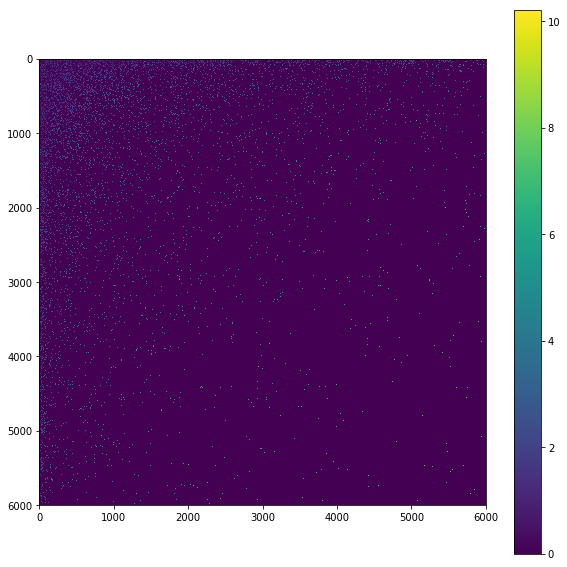

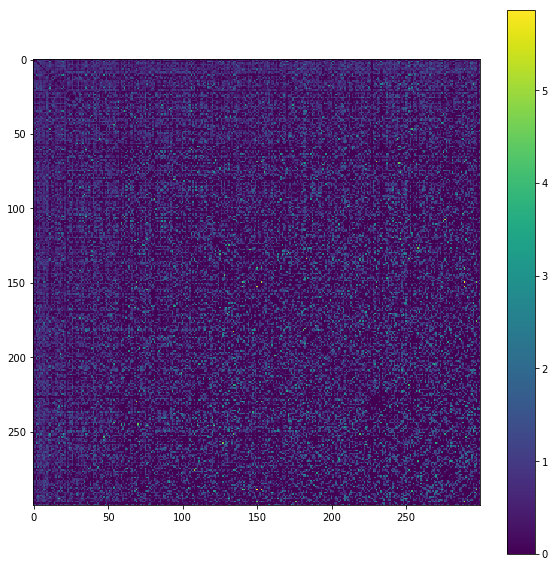

In [28]:
ppmi_matrix = matrix

# The whole PPMI matrix
ax, fig = plt.subplots(figsize=(10,10))
plt.imshow(ppmi_matrix)
plt.colorbar()
plt.show()

# Only the top-left corner (which hold the most frequent words)
ax, fig = plt.subplots(figsize=(10,10))
plt.imshow(ppmi_matrix[0:300, 0:300])
plt.colorbar()
plt.show()

YOUR ANSWER HERE

## Singular Value Decomposition

Now that we have the $PPMI$ co-occurence matrix, we are ready to compute its **singular value decomposition (SVD)**. 

### Definition

SVD is a very elegant linear algebra technique. It is defined as follows. Let $A \in \mathbb{R}^{m\times n}$, then the singular value decomposition of A is given by

$$A = U\Sigma V^{\top},$$

where:

* $U$ is an $m \times m$ **unitary** matrix.
    * A real-valued matrix $U$ is called unitary when $U^{\top}U = UU^{\top} = I$. In other words: $U$ forms an *orthonormal* basis for $\mathbb{R}^{m}$.
    
    
* $\Sigma$ is a **diagonal** $m \times n$ matrix with **non-negative real numbers**.

    * The diagonal values are the so called **singular values** $\sigma_1, \sigma_2,\dots,\sigma_n$ (supposing $n \leq m$). The convention is that in the matrix $\Sigma$ these are ordered from large to small: $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_n \geq 0$. 
    
    
* $V$ is an $n \times n$ **unitary** matrix (and $V^{\top}$ its transpose)


### Low-rank approximation

When we select only the first $k$ collums of $U$ and $V$ and the first $k$ singular values in $\Sigma$ we get 
* $\tilde{U} \in \mathbb{R}^{m \times k}$
* $\tilde{\Sigma} \in \mathbb{R}^{k \times k}$
* $\tilde{V} \in \mathbb{R}^{n \times k}.$


The reduced matrices can be used to make a rank $k$ matrix $\tilde{A} \in \mathbb{R}^{m\times n}$. The matrix $\tilde{A}$ is an approximation of the matrix $A$:

$$A \approx \tilde{U}\tilde{\Sigma} \tilde{V}^{\top} = \tilde{A}.$$

Moreover, this approximation is the 'best' approximation of $A$ in the sense that in minimizes the distance to $A$ in a type of matrix norm called the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm):
    
$$\tilde{A} = \arg \min_{A'} || A - A'||_{F}$$

----- 

You can learn more about SVD from these sources:

* [Jurafksy and Martin 16.1](https://web.stanford.edu/~jurafsky/slp3/16.pdf) (3rd edition)
* The [Wikipedia page](https://en.wikipedia.org/wiki/Singular-value_decomposition) (with a very good visual illustration)
* Or this long but good [blog-post series](https://jeremykun.com/2016/04/18/singular-value-decomposition-part-1-perspectives-on-linear-algebra/) (if you have some time!)

----------

For the purposes of this tutorial, however, all we need to know to get our embeddings is how to use SVD in python. And that is straightforward:

In [31]:
from scipy.linalg import svd

%time U, s, Vt = svd(ppmi_matrix)

CPU times: user 5min 8s, sys: 12.6 s, total: 5min 21s
Wall time: 3min 12s


## Reducing the dimension

Now we can create the rank $k$ matrix $\tilde{U}$ by selection only the first $k$ columns of $U$. The value $k$ will be the **embedding dimension** of our word vectors. Now we have our word embeddings! They are the rows of $\tilde{U}$.

In [32]:
k = 300
U_tilde = U[:,:k]

When we look at the word embeddings we can see that, unlike the full $PMI$ matrix, the vectors in $\tilde{U}$ are **dense**: almost all values non-zero.

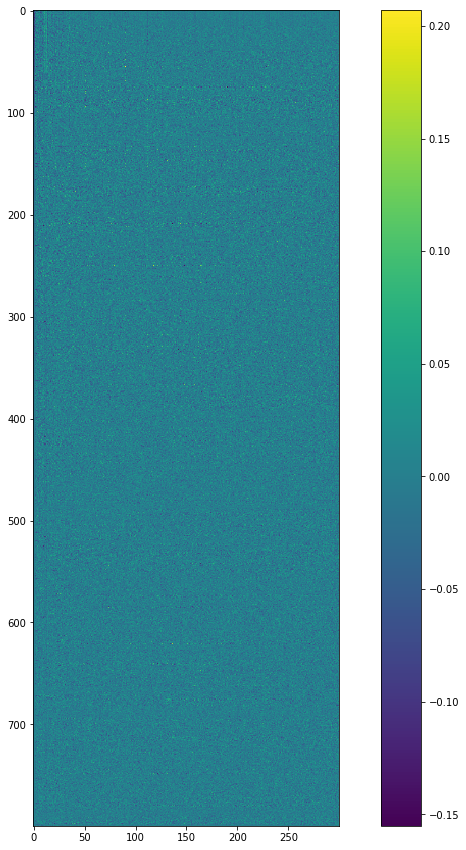

In [33]:
ax, fig = plt.subplots(figsize=(15,15))
plt.imshow(U_tilde[:800])
plt.colorbar()
plt.show()

## Visualization with t-SNE

A simple and rewarding way to evaluate to the word embeddings is by visualizing them.

When visualizing the vectors, we ideally show them in their $k$-dimensional vector space, but that is impossible to do. To plot them we need to reduce their dimension much beyond $k$.

A very popular method for this is [**t-SNE**](https://lvdmaaten.github.io/tsne/). t-SNE is a very effective technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. What it does is find a lower dimensional surface on which to project the high-dimensional data in such a way that the local structure of the original data is preserved as much as possible in the projected data. In simple words: data-points that are close to each other in the original space end up close to each other in the projected space. (Note: this does not hold large distances! Points that are far apart in the original space do not necessarily end up far apart in the projected space.) 

So, t-SNE is like Principal Component Analysis (PCA), another popular dimensionality reduction technique. But, due to the non-linear nature of the surface it finds (the 'manifold') t-SNE has more flexibility.

--------
If you want to know more about t-SNE you can read the following sources:
* [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/) on Distill discusses, among others, the effects of the *perplexity* parameter in t-SNE
* This [Scikit-learn example](http://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py)
--------

The code plots below uses **t-SNE** to make a two-dimensional plot with our word-embeddings. We also throw in some **K-means** clustering *in the original high-dimensional space* so that we can color our dimension-reduced word-embeddings. This gives us some for additional interpretative abilities.

In [777]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import d3
from bokeh.io import output_notebook
output_notebook()

def emb_scatter(data, names, perplexity=30.0, N=20):
    """
    Uses t-SNE with given perplexity to reduce the dimension of the 
    vectors in data to 2, plots these in a bokeh 2d scatter plot, 
    and colors them with N colors using K-means clustering of the 
    originial vectors. The colored dots are tagged with labels from
    the list names.
    
    :param data: numpy array of shape [num_vectors, embedding_dim]
    :param names: a list of words of length num_vectors in the same order as data
    :param perplexity: the perplexity for t-SNE
    :param N: the number of clusters to find by K-means
    """
    ## Try to find some clusters ##
    print("Finding clusters")
    kmeans = KMeans(n_clusters=N)
    kmeans.fit(data)
    klabels = kmeans.labels_

    ## Get a tsne fit ##
    print("Fitting tsne")
    tsne = TSNE(n_components=2, perplexity=perplexity)
    emb_tsne = tsne.fit_transform(data)
    
    ## Plot the tsne of the embeddings with bokeh ##
    # source: https://github.com/oxford-cs-deepnlp-2017/practical-1
    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="T-SNE for most common words")

    # Set colormap as a list
    colormap = d3['Category20'][N]
    colors = [colormap[i] for i in klabels]

    source = ColumnDataSource(data=dict(x1=emb_tsne[:,0],
                                        x2=emb_tsne[:,1],
                                        names=names,
                                        colors=colors))

    p.scatter(x="x1", y="x2", size=8, source=source, color='colors')

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)

    show(p)

Loading BokehJS ...

**(d)** Use the function `emb_scatter` to plot the word-vector in $\tilde{U}$. You are adviced to plot only the first 500-1000 word-vectors to make the resulting plot not too cluttered. **(10 points)**

Now go find some interesting clusters!

In [6]:
### YOUR CODE HERE

**(e)** Give a word cluster that you have found in the scatter plot that you think is particularly nice. **(10 points)**

YOUR ANSWER HERE

------

**You have reached the end of this notebook!** You can read on if you are interested.

Now, you can note that there are a number of hyperparameters in the model and its visualization that you can experiment with. **If you are motivated, you can experiment with these! But note that you are not required to do this.**

The options are:
* The pereplixity used in t-SNE has significant effects on the resulting visualization. Generally, values in the range 5-30 work well. If you have less data, or it is very high dimensional, you should go lower. If the data is packed closely together (lower dimension, more data), then higher perplexity generally works better.
* The embedding dimension $k$ of the vectors. We chose $k=300$, which is relatively standard in the literature. But you also see dimension 50,100, 150, 500, even 600. Do you notice differences? And why not just even use the original dimensions of $U$? 
* The number of words you use in the $PPMI$ matrix $P$. How few can you get away with? Is more always better?
* Use the matrix product $U\Sigma$ for the embeddings. The paper by Levy et al. (2015) below argues for this: select the first $k$ columns of $U\Sigma$ to give $\tilde{U\Sigma}$ as embeddings matrix. What this means is that each orthogonal vector $u_i$ is scaled by its singular value $\sigma_i$ to give $\sigma_i u_i$ before to reducing it to $\tilde{\sigma_i u_i}$.

How to evaluate the quality of word-embeddings quantitatively? Read the following for more information on the various evaluation methods developped for this:
* [Lecture notes](http://cs224d.stanford.edu/lecture_notes/notes2.pdf) from the Stanford course [Deep Learning for NLP](http://web.stanford.edu/class/cs224n/) 

The following paper compares a number the most popular word-embedding techniques with each. PPMI-SVD is one of them! Read the paper to get inspiration for your experiments to improve the above 'vanilla' implementation: 

* [Improving Distributional Similarity with Lessons Learned from Word Embeddings](http://www.aclweb.org/anthology/Q15-1016) (Levy et al. 2015)

The following blog-post contains an interesting discussion on why low dimensional embeddings often work better than very high-dimensional ones.
* [Word Embeddings: Explaining their properties](http://www.offconvex.org/2016/02/14/word-embeddings-2/) 

---

0.0
Iteration w_i at:  0
Iteration w_i at:  1000
Iteration w_i at:  2000
Iteration w_i at:  3000
Iteration w_i at:  4000
Iteration w_i at:  5000
Iteration w_i at:  6000
Iteration w_i at:  7000
Iteration w_i at:  8000
Iteration w_i at:  9000
[('cluett', 'fromstein', 12.690612311571964), ('cluett', 'gitano', 12.690612311571964), ('cluett', 'guterman', 12.690612311571964), ('cluett', 'hydro-quebec', 12.690612311571964), ('cluett', 'ipo', 12.690612311571964), ('fromstein', 'cluett', 12.690612311571964), ('fromstein', 'gitano', 12.690612311571964), ('fromstein', 'guterman', 12.690612311571964), ('fromstein', 'hydro-quebec', 12.690612311571964), ('fromstein', 'ipo', 12.690612311571964), ('fromstein', 'kia', 12.690612311571964), ('gitano', 'cluett', 12.690612311571964), ('gitano', 'fromstein', 12.690612311571964), ('gitano', 'guterman', 12.690612311571964), ('gitano', 'hydro-quebec', 12.690612311571964), ('gitano', 'ipo', 12.690612311571964), ('gitano', 'kia', 12.690612311571964), ('gitano', 'memotec', 12.690612311571964), ('guterman', 'cluett', 12.690612311571964), ('guterman', 'fromstein', 12.690612311571964), ('guterman', 'gitano', 12.690612311571964), ('guterman', 'hydro-quebec', 12.690612311571964), ('guterman', 'ipo', 12.690612311571964), ('guterman', 'kia', 12.690612311571964), ('guterman', 'memotec', 12.690612311571964), ('guterman', 'mlx', 12.690612311571964), ('hydro-quebec', 'cluett', 12.690612311571964), ('hydro-quebec', 'fromstein', 12.690612311571964), ('hydro-quebec', 'gitano', 12.690612311571964), ('hydro-quebec', 'guterman', 12.690612311571964)]
In [ ]:
